In [106]:
import numpy as np, pandas as pd, os
from sklearn.model_selection import cross_val_score, StratifiedKFold
import xgboost as xgb
import plotly.express as px, seaborn as sns, matplotlib.pyplot as plt
sns.set_style('darkgrid')
from sklearn.metrics import make_scorer, cohen_kappa_score
import eli5
from eli5.sklearn import PermutationImportance
import warnings
warnings.simplefilter('ignore')

In [107]:
train_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/train.csv")
test_df = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/test.csv")
sample = pd.read_csv("/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv")

In [108]:
train_df = train_df.dropna(subset='sii')
selected_columns = [
    'BIA-BIA_BMI', 'BIA-BIA_FFMI', 'BIA-BIA_Frame_num', 'Basic_Demos-Age', 'FGC-FGC_CU', 
    'FGC-FGC_PU', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'Physical-Height', 'Physical-Systolic_BP', 'Physical-Weight', 
    'PreInt_EduHx-computerinternet_hoursday', 'SDS-SDS_Total_T'
]
X = train_df[selected_columns] # Lấy các cột input (loại cột mục tiêu)
y = train_df['sii']  # Cột mục tiêu cho train

test = test_df[selected_columns]


# In ra thông tin X_train, y_train, X_test
print(X.shape, y.shape, test.shape)

(2736, 14) (2736,) (20, 14)


In [109]:
train_df[selected_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3958
Data columns (total 14 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   BIA-BIA_BMI                             1813 non-null   float64
 1   BIA-BIA_FFMI                            1813 non-null   float64
 2   BIA-BIA_Frame_num                       1813 non-null   float64
 3   Basic_Demos-Age                         2736 non-null   int64  
 4   FGC-FGC_CU                              1919 non-null   float64
 5   FGC-FGC_PU                              1909 non-null   float64
 6   FGC-FGC_SRL_Zone                        1877 non-null   float64
 7   FGC-FGC_SRR_Zone                        1879 non-null   float64
 8   FGC-FGC_TL                              1919 non-null   float64
 9   Physical-Height                         2530 non-null   float64
 10  Physical-Systolic_BP                    2478 non-null   float64
 

In [110]:
def quadratic_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')
kappa_scorer = make_scorer(quadratic_kappa)

In [111]:
params = {
    'max_depth': 3, 
    'n_estimators': 202,
    'learning_rate': 0.07956777025142073, 
    'subsample': 0.8197358255094112, 
    'colsample_bytree': 0.645036755035947
}
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': 42
}
skf = StratifiedKFold(n_splits=10)
clf = xgb.XGBClassifier(**XGB_Params)

In [112]:
scores = cross_val_score(clf, X, y, cv=skf, scoring=kappa_scorer, error_score='raise')
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.37167901 0.28276064 0.3384292  0.32332178 0.41959523 0.33017927
 0.36879397 0.44309866 0.32377919 0.32665331]
Mean QWK Score: 0.3528290263323836


In [113]:
clf.fit(X,y)
feature_imp = pd.Series(clf.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.151249
PreInt_EduHx-computerinternet_hoursday    0.127316
SDS-SDS_Total_T                           0.079203
Physical-Height                           0.073458
Physical-Weight                           0.069108
BIA-BIA_FFMI                              0.061647
FGC-FGC_CU                                0.059743
FGC-FGC_PU                                0.059306
Physical-Systolic_BP                      0.059095
BIA-BIA_BMI                               0.054887
FGC-FGC_TL                                0.054496
FGC-FGC_SRL_Zone                          0.052611
BIA-BIA_Frame_num                         0.050118
FGC-FGC_SRR_Zone                          0.047764
dtype: float32

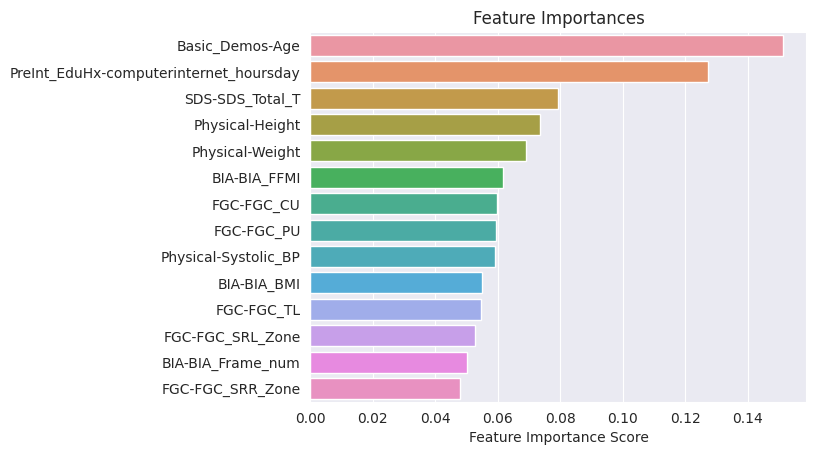

In [114]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [115]:
perm = PermutationImportance(clf, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1351 ± 0.0059,SDS-SDS_Total_T
0.0907 ± 0.0119,PreInt_EduHx-computerinternet_hoursday
0.0683 ± 0.0069,Physical-Systolic_BP
0.0672 ± 0.0060,BIA-BIA_FFMI
0.0637 ± 0.0062,Basic_Demos-Age
0.0548 ± 0.0043,Physical-Weight
0.0515 ± 0.0019,Physical-Height
0.0512 ± 0.0068,BIA-BIA_BMI
0.0485 ± 0.0039,FGC-FGC_CU
0.0438 ± 0.0061,FGC-FGC_PU


In [116]:
preds = clf.predict(test)
print(preds)

[2 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


In [117]:
y = train_df['PCIAT-PCIAT_Total']

In [118]:
def convert(scores):
    scores = np.array(scores)*1.252
    bins = np.zeros_like(scores)
    bins[scores <= 30] = 0
    bins[(scores > 30) & (scores < 50)] = 1
    bins[(scores >= 50) & (scores < 80)] = 2
    bins[scores >= 80] = 3
    return bins

In [119]:
def quadratic_kappa(y_true, y_pred):
    y_true_cat = convert(y_true)
    y_pred_cat = convert(y_pred)
    return cohen_kappa_score(y_true_cat, y_pred_cat, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa, greater_is_better=True)

In [120]:
params = {'max_depth': 3, 'n_estimators': 59, 'learning_rate': 0.07327652118259573, 'subsample': 0.5968194045365575, 'colsample_bytree': 0.9123669348125403}

In [121]:
model = xgb.XGBRegressor(**params)

In [122]:
scores = cross_val_score(model, X, y, cv=skf, scoring=kappa_scorer)
print("QWK Scores:", scores)
print("Mean QWK Score:", np.mean(scores))

QWK Scores: [0.36484057 0.45803371 0.54938495 0.43936294 0.49509554 0.42124474
 0.45662853 0.40612834 0.44111737 0.46502058]
Mean QWK Score: 0.4496857256397984


In [123]:
model.fit(X,y)
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp

Basic_Demos-Age                           0.274161
PreInt_EduHx-computerinternet_hoursday    0.133581
Physical-Height                           0.091251
SDS-SDS_Total_T                           0.084162
FGC-FGC_CU                                0.061421
Physical-Weight                           0.054217
FGC-FGC_PU                                0.051208
FGC-FGC_SRL_Zone                          0.047878
FGC-FGC_SRR_Zone                          0.040329
BIA-BIA_FFMI                              0.037300
Physical-Systolic_BP                      0.035396
BIA-BIA_Frame_num                         0.032827
FGC-FGC_TL                                0.029930
BIA-BIA_BMI                               0.026341
dtype: float32

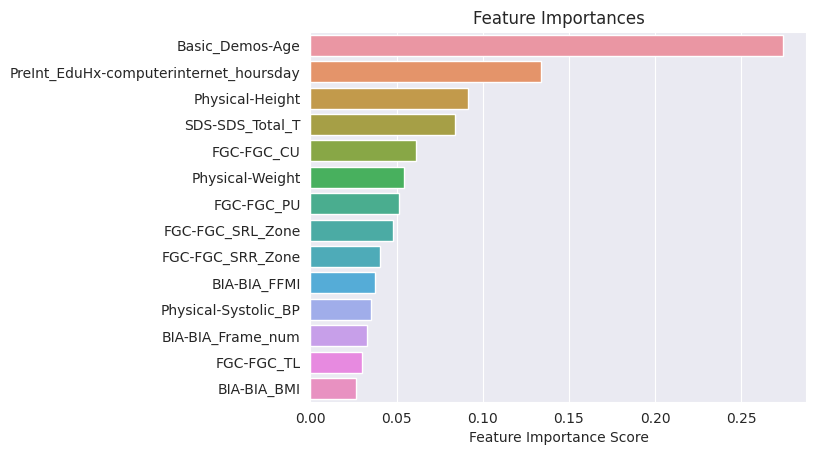

In [124]:
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.title("Feature Importances")
plt.show()

In [125]:
perm = PermutationImportance(model, random_state=1).fit(X,y)
eli5.show_weights(perm, feature_names = X.columns.tolist())

Weight,Feature
0.1134 ± 0.0233,PreInt_EduHx-computerinternet_hoursday
0.1086 ± 0.0118,SDS-SDS_Total_T
0.0942 ± 0.0178,Basic_Demos-Age
0.0342 ± 0.0038,Physical-Height
0.0272 ± 0.0036,FGC-FGC_CU
0.0177 ± 0.0020,Physical-Weight
0.0154 ± 0.0024,FGC-FGC_PU
0.0111 ± 0.0019,BIA-BIA_FFMI
0.0104 ± 0.0021,Physical-Systolic_BP
0.0045 ± 0.0010,BIA-BIA_BMI


In [126]:
model.fit(X,y)
preds = model.predict(test)
preds = convert(preds) # convert raw scores to sii categories if using regressor
preds = pd.Series(preds)


In [127]:
Submission = pd.DataFrame({
    'id': sample['id'],
    'sii': preds
})
Submission.to_csv('submission.csv', index=False)
print(Submission['sii'].value_counts())

sii
1.0    16
0.0     4
Name: count, dtype: int64
